本文主要以kaggle一次二分类竞赛数据为例，深入研究改进forest

LayerDTree是LayerForest的精简版，是对Forest进一步探索的基础

- 数据地址：https://www.kaggle.com/c/porto-seguro-safe-driver-prediction
- 数据特点：
  - 非常不均衡、缺失值严重、二分类
- 包含内容：
  1. 数据获取
  2. 模型应用
  3. 结果分析

# Stage-1：获取数据

In [1]:
import os
import numpy as np
import pandas as pd
import time
import os.path as osp

In [2]:
class FeatureParser(object):
    def __init__(self, desc):
        desc = desc.strip()
        if desc == "C":
            self.f_type = "number"
        else:
            self.f_type = "categorical"
            f_names = [d.strip() for d in desc.split(",")]
            # missing value
            f_names.insert(0, "?")
            self.name2id = dict(zip(f_names, range(len(f_names))))

    def get_float(self, f_data):
        f_data = f_data.strip()
        if self.f_type == "number":
            return float(f_data)
        return float(self.name2id[f_data])

    def get_data(self, f_data):
        f_data = f_data.strip()
        if self.f_type == "number":
            return float(f_data)
        data = np.zeros(len(self.name2id), dtype=np.float32)
        data[self.name2id[f_data]] = 1
        return data

    def get_fdim(self):
        """
        get feature dimension
        """
        if self.f_type == "number":
            return 1
        return len(self.name2id)

In [3]:
train_data_path = osp.join(".\\datasetes", "adult", "adult.data")
test_data_path = osp.join(".\\datasetes", "adult", "adult.test")
feature_desc_path = osp.join(".\\datasetes", "adult", "features")
train_data_path, test_data_path, feature_desc_path

('.\\datasetes\\adult\\adult.data',
 '.\\datasetes\\adult\\adult.test',
 '.\\datasetes\\adult\\features')

In [4]:
f_parsers = []
with open(feature_desc_path) as f:
    for row in f.readlines():
        f_parsers.append(FeatureParser(row))
# f_parsers

In [5]:
with open(train_data_path) as f:
    rows = [row.strip().split(",") for row in f.readlines() if len(row.strip()) > 0 and not row.startswith("|")]
n_datas = len(rows)

cate_as_onehot = 0
if cate_as_onehot:
    X_dim = np.sum([f_parser.get_fdim() for f_parser in f_parsers])
    X = np.zeros((n_datas, X_dim), dtype=np.float32)
else:
    X = np.zeros((n_datas, 14), dtype=np.float32)
y = np.zeros(n_datas, dtype=np.int32)
for i, row in enumerate(rows):
    assert len(row) == 15, "len(row) wrong, i={}".format(i)
    foffset = 0
    for j in range(14):
        if cate_as_onehot:
            fdim = f_parsers[j].get_fdim()
            X[i, foffset:foffset+fdim] = f_parsers[j].get_data(row[j].strip())
            foffset += fdim
        else:
            X[i, j] = f_parsers[j].get_float(row[j].strip())
    y[i] = 0 if row[-1].strip().startswith("<=50K") else 1
print(X.shape, y.shape)
X_train = X
y_train = y

(32561, 14) (32561,)


In [6]:
with open(test_data_path) as f:
    rows = [row.strip().split(",") for row in f.readlines() if len(row.strip()) > 0 and not row.startswith("|")]
n_datas = len(rows)

cate_as_onehot = 0
if cate_as_onehot:
    X_dim = np.sum([f_parser.get_fdim() for f_parser in f_parsers])
    X = np.zeros((n_datas, X_dim), dtype=np.float32)
else:
    X = np.zeros((n_datas, 14), dtype=np.float32)
y = np.zeros(n_datas, dtype=np.int32)
for i, row in enumerate(rows):
    assert len(row) == 15, "len(row) wrong, i={}".format(i)
    foffset = 0
    for j in range(14):
        if cate_as_onehot:
            fdim = f_parsers[j].get_fdim()
            X[i, foffset:foffset+fdim] = f_parsers[j].get_data(row[j].strip())
            foffset += fdim
        else:
            X[i, j] = f_parsers[j].get_float(row[j].strip())
    y[i] = 0 if row[-1].strip().startswith("<=50K") else 1
print(X.shape, y.shape)
X_sub = X
y_sub = y

(16281, 14) (16281,)


# Stage-2：模型应用

In [7]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import ForestUtils
import time
import random
from sklearn import metrics

In [8]:
import EnhancedDTree
import EnhancedForest
import importlib

In [9]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [10]:
importlib.reload(EnhancedForest)

<module 'EnhancedForest' from 'C:\\github_workspace\\LayerForest\\EnhancedForest.py'>

# 决策树算法

In [11]:
clf = DecisionTreeClassifier()
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [12]:
clf = clf.fit(X_train, y_train)

In [13]:
p_train = clf.predict_proba(X_sub)
p_train = [item[1] for item in p_train]
p_train = np.array(p_train)
print("data auc", metrics.roc_auc_score(y_sub, p_train))

data auc 0.744620889781


In [14]:
p_train = clf.predict(X_sub)
print("data auc", metrics.accuracy_score(y_sub, p_train))

data auc 0.81413918064


# 随机森林算法

In [30]:
rf = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=4, random_state=1024, verbose=True, min_samples_leaf=10)
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
            oob_score=False, random_state=1024, verbose=True,
            warm_start=False)

In [31]:
rf.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
            oob_score=False, random_state=1024, verbose=True,
            warm_start=False)

In [75]:
p_train = rf.predict_proba(X_sub)
p_train = [item[1] for item in p_train]
p_train = np.array(p_train)
print("data auc", metrics.roc_auc_score(y_sub, p_train))
print("data log", metrics.log_loss(y_sub, p_train))

data auc 0.913582600401
data log 0.305620201341


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


In [33]:
p_train = rf.predict(X_sub)
print("data acc", metrics.accuracy_score(y_sub, p_train))

data acc 0.859468091641


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


# XGB算法

In [34]:
import xgboost as xgb

In [35]:
params = {
    'objective': 'binary:logistic',
    'silent': True,
    
    'max_depth': 4,
    'eta': 0.020,
    'gamma': 0.65,
    
    'colsample_bytree': 0.8,
    'subsample': 0.6,
    
    'num_boost_round' : 700,
#     'min_child_weight': 10.0,
#     'max_delta_step': 1.8,
}

In [40]:
# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def ginic(actual, pred):
    actual = np.asarray(actual) #In case, someone passes Series or list
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n

def gini_normalized(a, p):
#     if p.ndim == 2:#Required for sklearn wrapper
#         p = p[:,1] #If proba array contains proba for both 0 and 1 classes, just pick class 1
    return ginic(a, p) / ginic(a, a)

# Create an XGBoost-compatible metric from Gini
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

In [41]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=9487)
split_obj = tuple(sss.split(X_train, y_train))
train_index, test_index = split_obj[0]
X_1, X_2 = X_train[train_index], X_train[test_index]
y_1, y_2 = y_train[train_index], y_train[test_index]

In [53]:
d_train = xgb.DMatrix(X_1, y_1)
d_valid = xgb.DMatrix(X_2, y_2)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

mdl = xgb.train(params, d_train, 
                    num_boost_round=1600, evals=watchlist, early_stopping_rounds=100, 
                    feval=gini_xgb, 
                maximize=True, verbose_eval=100)

[0]	train-gini:0.733609	valid-gini:0.747175
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.819033	valid-gini:0.830781
[200]	train-gini:0.835378	valid-gini:0.841774
[300]	train-gini:0.847153	valid-gini:0.850935
[400]	train-gini:0.855213	valid-gini:0.85705
[500]	train-gini:0.861247	valid-gini:0.861422
[600]	train-gini:0.866001	valid-gini:0.86377
[700]	train-gini:0.869949	valid-gini:0.866444
[800]	train-gini:0.873283	valid-gini:0.867649
[900]	train-gini:0.876298	valid-gini:0.86842
[1000]	train-gini:0.878976	valid-gini:0.8688
[1100]	train-gini:0.881416	valid-gini:0.869299
[1200]	train-gini:0.883904	valid-gini:0.869325
Stopping. Best iteration:
[1139]	train-gini:0.882537	valid-gini:0.86963



In [36]:
d_test = xgb.DMatrix(X_sub)
p_train = mdl.predict(d_test)
print("data auc", metrics.roc_auc_score(y_sub, p_train))

data auc 0.92632245137


In [37]:
metrics.roc_auc_score(y_sub, p_train), metrics.log_loss(y_sub, p_train), 2*metrics.roc_auc_score(y_sub, p_train)-1

(0.92632245137010949, 0.27896588252501475, 0.85264490274021898)

In [38]:
d_test = xgb.DMatrix(X_sub)
p_train = mdl.predict(d_test)
print("data auc", metrics.log_loss(y_sub, p_train))

data auc 0.278965882525


In [39]:
d_test = xgb.DMatrix(X_sub)
p_train = mdl.predict(d_test)
print("data auc", metrics.roc_auc_score(y_sub, p_train))

data auc 0.92632245137


In [40]:
test_y_acc_index = np.where(p_train > 0.5)[0]
test_y_acc = np.array([0] * len(p_train))
test_y_acc[test_y_acc_index] = 1
metrics.accuracy_score(y_sub, test_y_acc)

0.87420920090903509

# layerDTree算法

In [41]:
importlib.reload(EnhancedForest)

<module 'EnhancedForest' from 'C:\\github_workspace\\LayerForest\\EnhancedForest.py'>

In [42]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_metrix(a, p):
    return "nor gini:", gini_normalized(a,p)

In [43]:
def mse_metrix(a, p):
    return "mse:", metrics.mean_squared_error(a,p,labels=labels)

In [44]:
def log_loss_metrix(a, p, labels):
    return "log:", metrics.log_loss(a,p,labels=labels)

In [210]:
X = X_train.copy()
y = y_train.copy()

X_test = X_sub.copy()
test_y = np.array(([0.0] * len(X_test)))
all_data_mask = np.array([False] * len(X_test))
real_y = y_sub.copy()

# 均衡数据进行layer
X_train_np = X
y_train_np = y
maxlayer = 100
layer = 0

enhancedForest = EnhancedForest.EnhancedForest()
counter = 0
while 1:
    layer += 1
    X = X_train_np
    y = y_train_np
    
    # 均衡数据
    positive_mask = np.where(y == 1)[0]
    negative_index = np.where(y == 0)[0]
    random.shuffle(negative_index)
    negative_mask = negative_index[:len(positive_mask)]
    train_mask = np.hstack((positive_mask, negative_mask))
    train_data_x = X[train_mask]
    train_data_y = y[train_mask]
    guest_mask = negative_index[len(positive_mask):]
    guest_data_x = X[guest_mask]
    guest_data_y = y[guest_mask]
    
#     print("train==1", train_data_y[train_data_y == 1].shape)
#     print("train==0", train_data_y[train_data_y == 0].shape)
    clf, data_mask, all_false_data_index, p_test  = \
        enhancedForest.TrainModelLayer(train_data_x, train_data_y, X_test, all_data_mask, test_y, real_y, verbose=False, feval=gini_metrix)
        
    X_train_np = enhancedForest.X_train_np
    y_train_np = enhancedForest.y_train_np
    
    # 均衡数据
    X_train_np = np.vstack((X_train_np, guest_data_x))
    y_train_np = np.hstack((y_train_np, guest_data_y))
#     print("train==1", y_train_np[y_train_np == 1].shape)
#     print("train==0", y_train_np[y_train_np == 0].shape)
    pass_data_id = data_mask[data_mask==True]
    all_false_data_index = np.where(all_data_mask == False)[0]
    X_test_np = X_test[all_false_data_index]
    print("%d [%d/%d] " % (layer, len(pass_data_id), len(X_test_np) - len(pass_data_id)), end="")
    
    if X_train_np.shape[0] < 1000 or y_train_np[y_train_np==1].shape[0] <= 10 \
        or layer > maxlayer \
        or len(p_test[~data_mask]) == 0:
        all_data_mask = all_false_data_index[~data_mask]
        test_y[all_data_mask] = p_test[~data_mask]
        print(len(p_test[~data_mask]))
        break
        
    all_data_mask[~all_data_mask] = data_mask

[1533/255|14149/7586] 1 [2064/14217] [952/54|14220/7532] 2 [447/13770] [683/74|14381/7458] 3 [162/13608] [627/44|14289/7414] 4 [183/13425] [416/28|14412/7386] 5 [143/13282] [369/28|14403/7358] 6 [120/13162] [295/44|14421/7314] 7 [110/13052] [218/13|14410/7301] 8 [66/12986] [218/6|14384/7295] 9 [84/12902] [183/16|14407/7279] 10 [77/12825] [116/24|14442/7255] 11 [48/12777] [100/8|14410/7247] 12 [32/12745] [137/36|14357/7211] 13 [56/12689] [110/6|14312/7205] 14 [26/12663] [93/24|14317/7181] 15 [31/12632] [94/5|14268/7176] 16 [19/12613] [60/0|14292/7176] 17 [21/12592] [69/5|14283/7171] 18 [23/12569] [55/4|14287/7167] 19 [17/12552] [203/12|14131/7155] 20 [117/12435] [60/2|14250/7153] 21 [26/12409] [68/2|14238/7151] 22 [40/12369] [36/3|14266/7148] 23 [12/12357] [90/0|14206/7148] 24 [37/12320] [78/9|14218/7139] 25 [29/12291] [83/2|14195/7137] 26 [40/12251] [33/2|14241/7135] 27 [9/12242] [38/2|14232/7133] 28 [11/12231] [44/4|14222/7129] 29 [26/12205] [38/0|14220/7129] 30 [16/12189] [80/1|14178

In [ ]:
 print("[%d/%d|%d/%d] " % (len(X_train_pass), len(positive_pass), len(X_train_np), len(positive)), end="")

In [160]:
# 均衡数据进行layer

In [211]:
metrics.roc_auc_score(y_sub, test_y)

0.91377586748021578

In [199]:
metrics.roc_auc_score(y_sub, test_y)

0.91294039457597598

In [74]:
test_y_acc_index = np.where(test_y > 0.5)[0]
test_y_acc = np.array([0] * len(test_y))
test_y_acc[test_y_acc_index] = 1
metrics.accuracy_score(y_sub, test_y_acc)

0.82777470671334685

In [ ]:
# 不均衡数据进行layer

In [69]:
# train cv dropout 0.8
metrics.roc_auc_score(y_sub, test_y), metrics.log_loss(y_sub, test_y), 2*metrics.roc_auc_score(y_sub, test_y)-1

(0.9083394336979751, 0.33282957275793523, 0.81667886739595019)

In [129]:
# train cv dropout 0.95 not gini
metrics.roc_auc_score(y_sub, test_y), metrics.log_loss(y_sub, test_y), 2*metrics.roc_auc_score(y_sub, test_y)-1

(0.91451854374938968, 0.31028064269762012, 0.82903708749877936)

In [122]:
# train cv dropout 0.5
metrics.roc_auc_score(y_sub, test_y), metrics.log_loss(y_sub, test_y), 2*metrics.roc_auc_score(y_sub, test_y)-1

(0.90880380370019798, 0.32767291469088039, 0.81760760740039595)

In [190]:
# test cv no dropout
metrics.roc_auc_score(y_sub, test_y), metrics.log_loss(y_sub, test_y), 2*metrics.roc_auc_score(y_sub, test_y)-1

(0.91007481232100107, 0.31516972378271974, 0.82014962464200214)

In [215]:
# test cv no dropout F1
metrics.roc_auc_score(y_sub, test_y), metrics.log_loss(y_sub, test_y), 2*metrics.roc_auc_score(y_sub, test_y)-1

(0.9138259772449604, 0.30718407224655275, 0.82765195448992079)

In [256]:
# test cv no dropout F1 theroshold 0.01 n=10
metrics.roc_auc_score(y_sub, test_y), metrics.log_loss(y_sub, test_y), 2*metrics.roc_auc_score(y_sub, test_y)-1

(0.91334004948456871, 0.309044863130014, 0.82668009896913741)

In [263]:
# test cv no dropout F1 theroshold 0.01 n=100
metrics.roc_auc_score(y_sub, test_y), metrics.log_loss(y_sub, test_y), 2*metrics.roc_auc_score(y_sub, test_y)-1

(0.91419665150096152, 0.30601056502471485, 0.82839330300192304)

In [274]:
# test cv no dropout F1 theroshold 0.01 n=100 random=layer no down
metrics.roc_auc_score(y_sub, test_y), metrics.log_loss(y_sub, test_y), 2*metrics.roc_auc_score(y_sub, test_y)-1

(0.91408725267386237, 0.30633229686311797, 0.82817450534772474)

In [322]:
# test cv no dropout F1 theroshold 0.01 n=100 random=layer no down debug
metrics.roc_auc_score(y_sub, test_y), metrics.log_loss(y_sub, test_y), 2*metrics.roc_auc_score(y_sub, test_y)-1

(0.91399003366648546, 0.3066658799687107, 0.82798006733297091)

In [100]:
metrics.roc_auc_score(y_sub, test_y), metrics.log_loss(y_sub, test_y), 2*metrics.roc_auc_score(y_sub, test_y)-1

(0.91418757675116025, 0.30677497047315805, 0.82837515350232049)

In [385]:
metrics.roc_auc_score(y_sub, test_y), metrics.log_loss(y_sub, test_y), 2*metrics.roc_auc_score(y_sub, test_y)-1

(0.9143917272573493, 0.30593494585638092, 0.82878345451469859)

In [230]:
metrics.roc_auc_score(y_sub, test_y)

0.91408542308720908

In [189]:
test_y_acc_index = np.where(test_y > 0.5)[0]
test_y_acc = np.array([0] * len(test_y))
test_y_acc[test_y_acc_index] = 1
metrics.accuracy_score(y_sub, test_y_acc)

0.86167925803083345

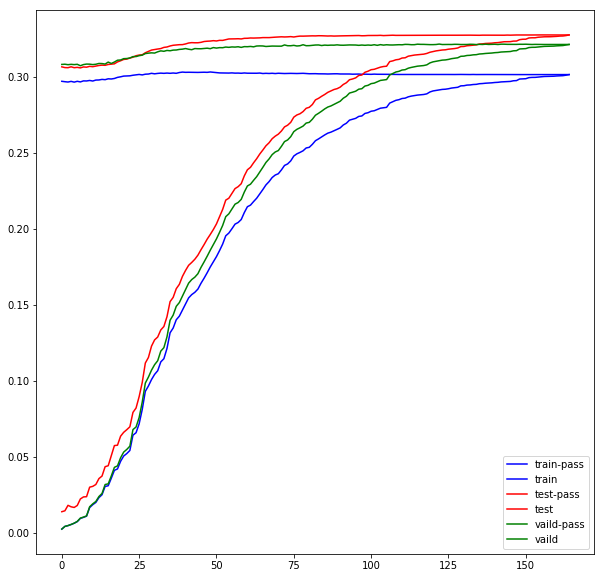

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))
# plt.plot(x,train_loss_lt)
plt.plot(x,pass_train_loss_lt, label="train-pass", color="blue")
plt.plot(x,train_loss_lt, label="train", color="blue")
x = range(len(test_loss_lt))
plt.plot(x,pass_test_loss_lt, label="test-pass", color="red")
plt.plot(x,test_loss_lt, label="test", color="red")
x = range(len(vaild_loss_lt))
plt.plot(x,pass_vaild_loss_lt, label="vaild-pass", color="green")
plt.plot(x,vaild_loss_lt, label="vaild", color="green")

plt.legend()
plt.show()

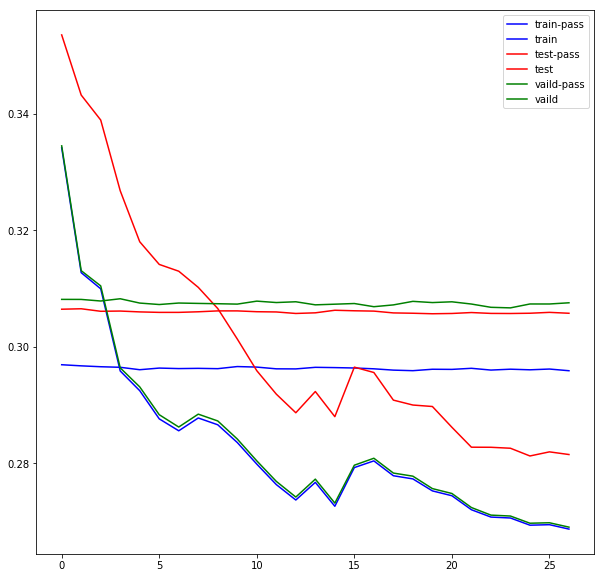

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))
# plt.plot(x,train_loss_lt)
plt.plot(x,pass_train_loss_lt, label="train-pass", color="blue")
plt.plot(x,train_loss_lt, label="train", color="blue")
x = range(len(test_loss_lt))
plt.plot(x,pass_test_loss_lt, label="test-pass", color="red")
plt.plot(x,test_loss_lt, label="test", color="red")
x = range(len(vaild_loss_lt))
plt.plot(x,pass_vaild_loss_lt, label="vaild-pass", color="green")
plt.plot(x,vaild_loss_lt, label="vaild", color="green")

plt.legend()
plt.show()

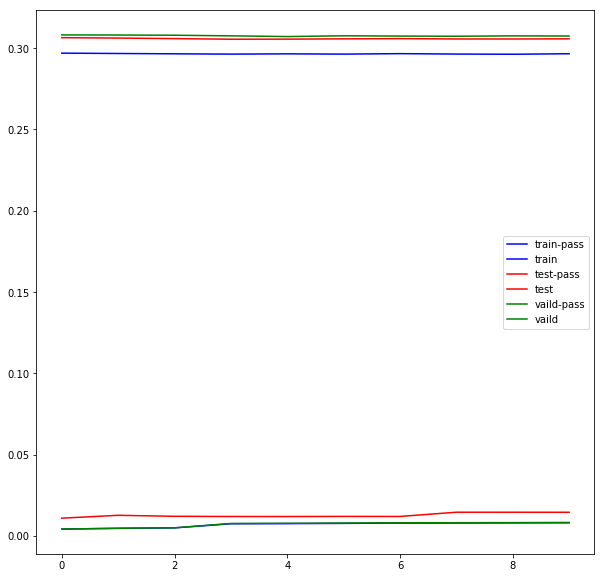

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))
# plt.plot(x,train_loss_lt)
plt.plot(x,pass_train_loss_lt, label="train-pass", color="blue")
plt.plot(x,train_loss_lt, label="train", color="blue")
x = range(len(test_loss_lt))
plt.plot(x,pass_test_loss_lt, label="test-pass", color="red")
plt.plot(x,test_loss_lt, label="test", color="red")
x = range(len(vaild_loss_lt))
plt.plot(x,pass_vaild_loss_lt, label="vaild-pass", color="green")
plt.plot(x,vaild_loss_lt, label="vaild", color="green")

plt.legend()
plt.show()

## 1. pass data

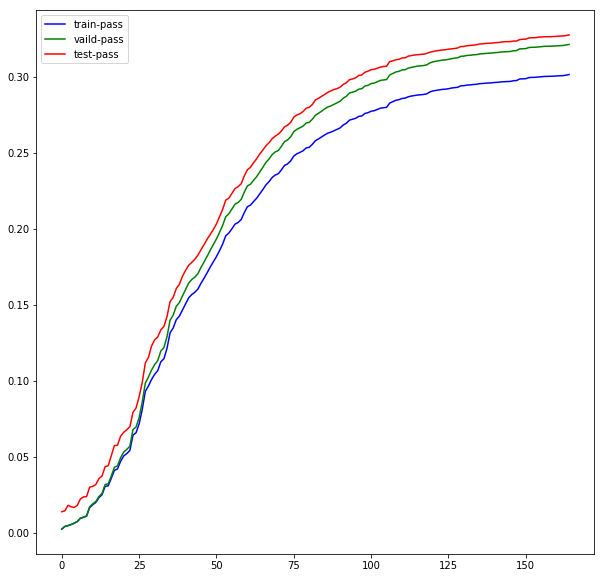

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))
plt.plot(x,pass_train_loss_lt, label="train-pass", color="blue")
plt.plot(x,pass_vaild_loss_lt, label="vaild-pass", color="green")
plt.plot(x,pass_test_loss_lt, label="test-pass", color="red")

plt.legend()
plt.show()

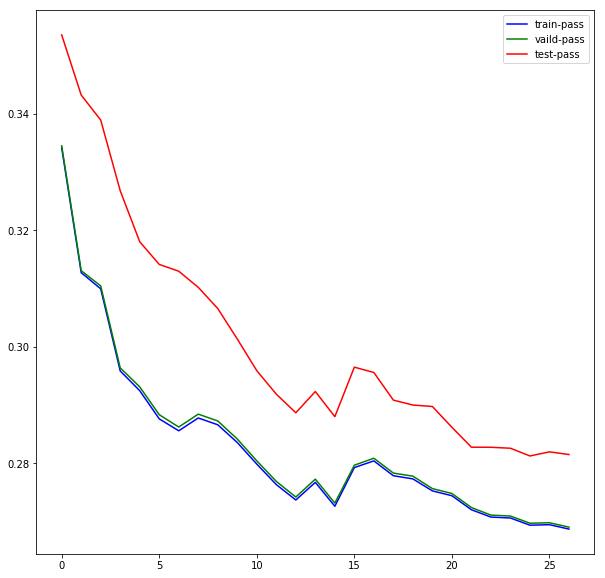

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))
plt.plot(x,pass_train_loss_lt, label="train-pass", color="blue")
plt.plot(x,pass_vaild_loss_lt, label="vaild-pass", color="green")
plt.plot(x,pass_test_loss_lt, label="test-pass", color="red")

plt.legend()
plt.show()

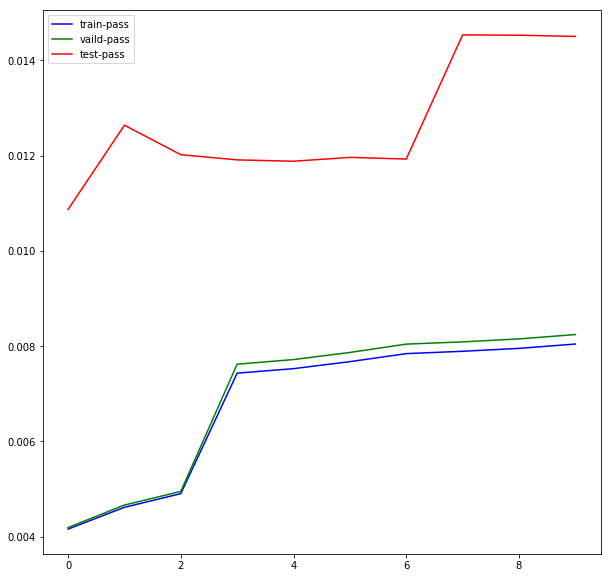

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))
plt.plot(x,pass_train_loss_lt, label="train-pass", color="blue")
plt.plot(x,pass_vaild_loss_lt, label="vaild-pass", color="green")
plt.plot(x,pass_test_loss_lt, label="test-pass", color="red")

plt.legend()
plt.show()

## 1. pass now data loss

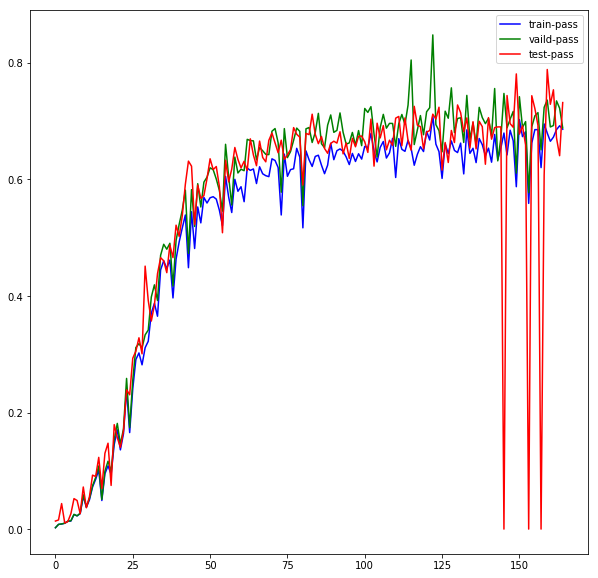

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))
plt.plot(x,pass_train_loss_lt_now, label="train-pass", color="blue")
plt.plot(x,pass_vaild_loss_lt_now, label="vaild-pass", color="green")
plt.plot(x,pass_test_loss_lt_now, label="test-pass", color="red")

plt.legend()
plt.show()

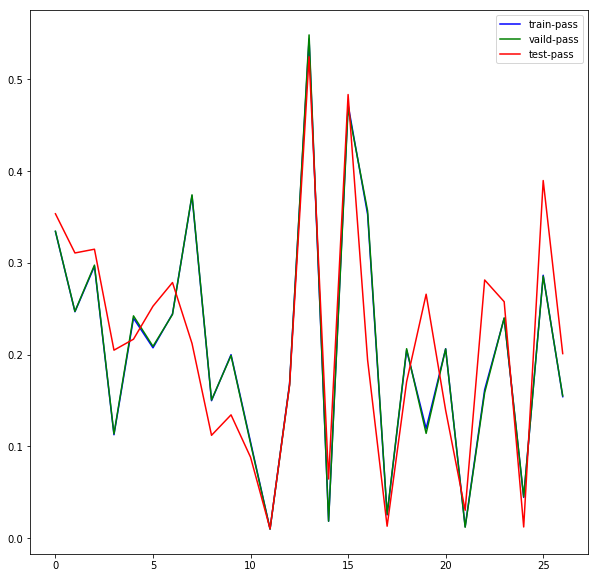

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))
plt.plot(x,pass_train_loss_lt_now, label="train-pass", color="blue")
plt.plot(x,pass_vaild_loss_lt_now, label="vaild-pass", color="green")
plt.plot(x,pass_test_loss_lt_now, label="test-pass", color="red")

plt.legend()
plt.show()

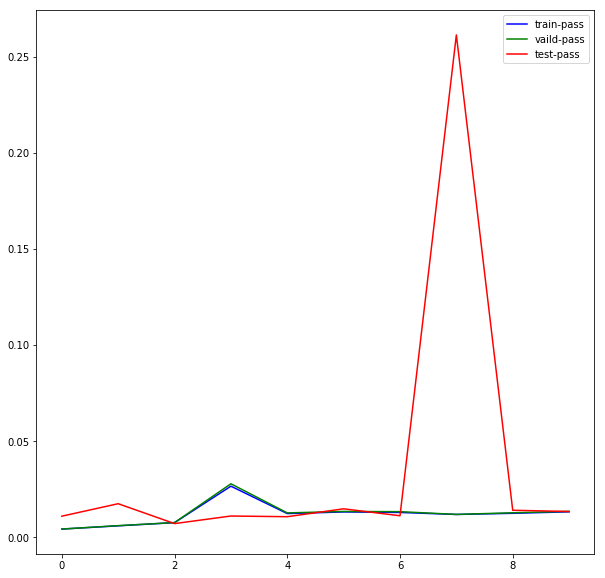

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))
plt.plot(x,pass_train_loss_lt_now, label="train-pass", color="blue")
plt.plot(x,pass_vaild_loss_lt_now, label="vaild-pass", color="green")
plt.plot(x,pass_test_loss_lt_now, label="test-pass", color="red")

plt.legend()
plt.show()

## 2. train test loss

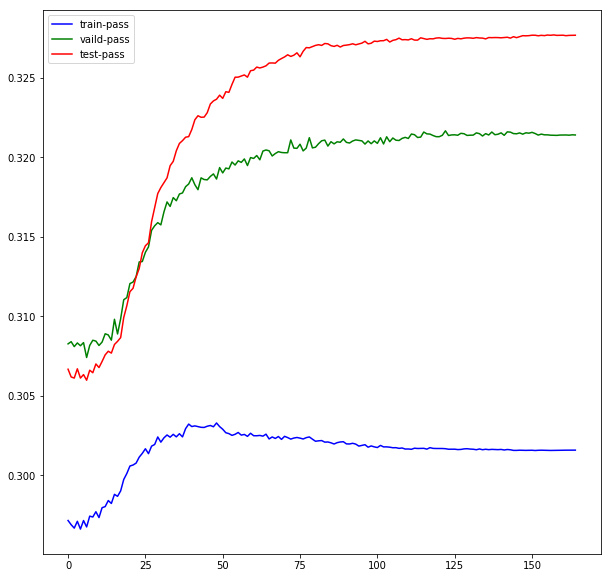

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))
plt.plot(x,train_loss_lt, label="train-pass", color="blue")
plt.plot(x,vaild_loss_lt, label="vaild-pass", color="green")
plt.plot(x,test_loss_lt, label="test-pass", color="red")

plt.legend()
plt.show()

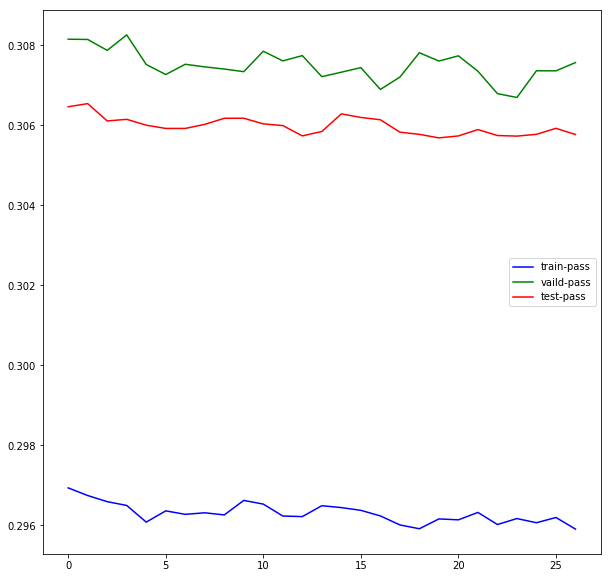

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))
plt.plot(x,train_loss_lt, label="train-pass", color="blue")
plt.plot(x,vaild_loss_lt, label="vaild-pass", color="green")
plt.plot(x,test_loss_lt, label="test-pass", color="red")

plt.legend()
plt.show()

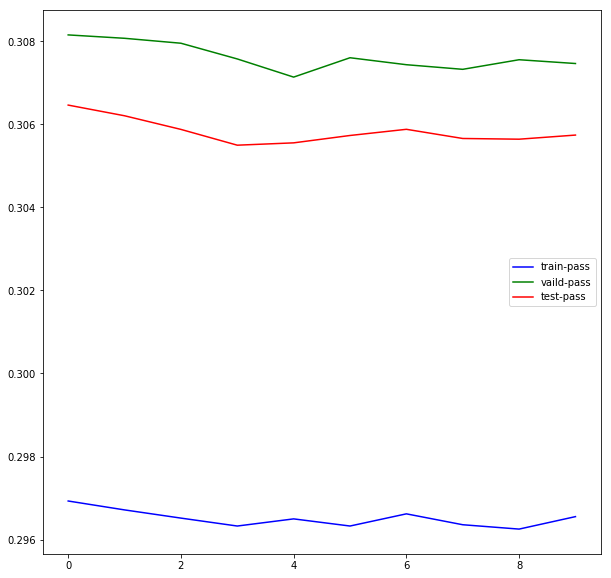

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))
plt.plot(x,train_loss_lt, label="train-pass", color="blue")
plt.plot(x,vaild_loss_lt, label="vaild-pass", color="green")
plt.plot(x,test_loss_lt, label="test-pass", color="red")

plt.legend()
plt.show()

## 3. data rate

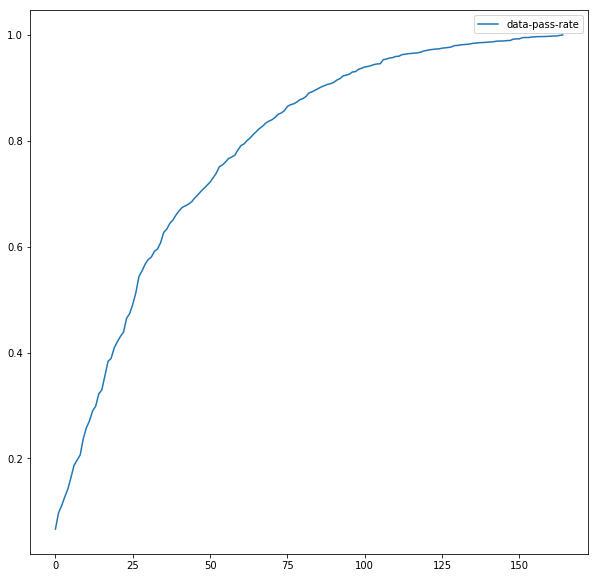

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))
plt.plot(x,pass_data_rate_lt[:], label="data-pass-rate")

plt.legend()
plt.show()

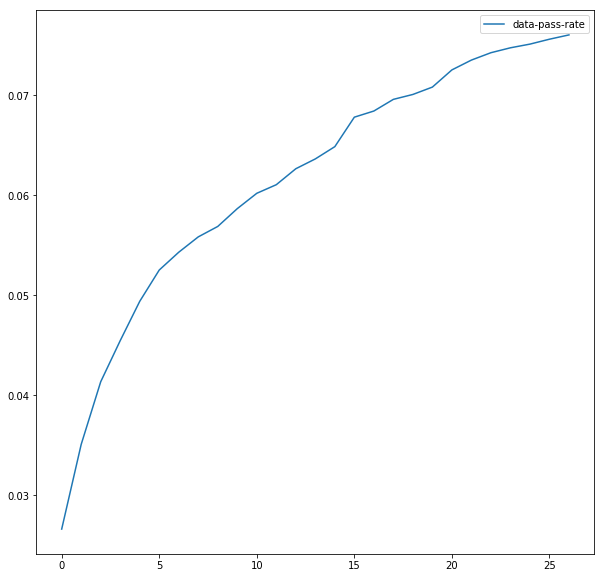

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))
plt.plot(x,pass_data_rate_lt[:], label="data-pass-rate")

plt.legend()
plt.show()

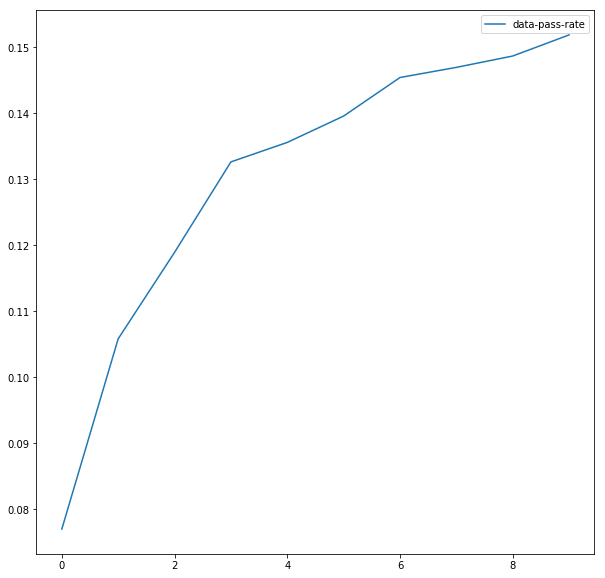

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))
plt.plot(x,pass_data_rate_lt[:], label="data-pass-rate")

plt.legend()
plt.show()

In [45]:
np.seterr(divide='ignore', invalid='ignore')
# with np.seterr(divide='ignore', invalid='ignore'):

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [107]:
importlib.reload(EnhancedForest)

<module 'EnhancedForest' from 'C:\\github_workspace\\LayerForest\\EnhancedForest.py'>

In [108]:
# 统计信息
train_loss_lt = []
pass_train_loss_lt = []
pass_train_loss_lt_now = []
vaild_loss_lt = []
pass_vaild_loss_lt = []
pass_vaild_loss_lt_now = []
test_loss_lt = []
pass_test_loss_lt = []
pass_test_loss_lt_now = []
pass_data_rate_lt = []

# 数据
X = X_train.copy()
y = y_train.copy()

X_test = X_sub.copy()
test_y = np.array(([0.0] * len(X_test)))
all_data_mask = np.array([False] * len(X_test))
real_y = y_sub.copy()

# 不均衡数据进行layer
X_train_np = X
y_train_np = y
maxlayer = 500
layer = 0

# 不降低不更新
last_train_loss = 1
last_vaild_loss = 1

enhancedDTree = EnhancedForest.EnhancedForest(len(X_train), len(X_test))
counter = 0
early_stop = 0
early_stop_up = 0
while 1:
    layer += 1
    print()
    print("layer:", layer)
    X = X_train_np
    y = y_train_np
    if layer == 1: isFirst = True
    else: isFirst = False
    clf, data_mask, all_false_data_index, p_test = \
        enhancedDTree.TrainModelLayer(X, y, X_test, all_data_mask, test_y, real_y, verbose=False, \
                                      feval=log_loss_metrix, dropout=None, criterion='entropy', random_state=layer, \
                                      isFirst=isFirst\
                                     )
    
    train_loss = enhancedDTree.getTrainLoss(log_loss_metrix)
    pass_train_loss = enhancedDTree.getPassTrainLoss(log_loss_metrix)
    pass_train_loss_now = enhancedDTree.getPassTrainLossNow(log_loss_metrix)
    vaild_loss = enhancedDTree.getVaildLoss(log_loss_metrix)
    pass_vaild_loss = enhancedDTree.getPassVaildLoss(log_loss_metrix)
    pass_vaild_loss_now = enhancedDTree.getPassVaildLossNow(log_loss_metrix)
    test_loss = enhancedDTree.getTestLoss(log_loss_metrix)
    pass_test_loss = enhancedDTree.getPassTestLoss(log_loss_metrix)
    pass_test_loss_now = enhancedDTree.getPassTestLossNow(log_loss_metrix)
    
#     if train_loss[1] > last_train_loss and vaild_loss[1] > last_vaild_loss: 
    if vaild_loss[1] > last_vaild_loss: 
        if not isFirst: enhancedDTree.remove_last_items()
#         early_stop_up += 1
        if layer > maxlayer or early_stop > 5 or early_stop_up > 15:
            break
        continue
        
    last_train_loss = train_loss[1]
    last_vaild_loss = vaild_loss[1]
    
    X_train_np = enhancedDTree.X_train_np
    y_train_np = enhancedDTree.y_train_np
    
    # 打印信息
    pass_data_id = data_mask[data_mask==True]
#     all_false_data_index = np.where(all_data_mask == False)[0]
    X_test_np = X_test[all_false_data_index]
    print("%d [p:%d/np:%d] " % (layer, len(pass_data_id), len(X_test_np) - len(pass_data_id)))#, end="")
    if len(pass_data_id) == 0: early_stop += 1
        
    print("train loss", train_loss)
    print("pass train loss", pass_train_loss)
    print("pass train loss now", pass_train_loss_now)
    print("vaild loss", vaild_loss)
    print("pass vaild loss", pass_vaild_loss)
    print("pass vaild loss now", pass_vaild_loss_now)
    print("test loss", test_loss)
    print("pass test loss", pass_test_loss)
    print("pass test loss now", pass_test_loss_now)
    
    
#     tmp_all_data_mask = all_false_data_index[~data_mask]
#     test_y[tmp_all_data_mask] = p_test[~data_mask]
    tmp_test_loss = metrics.log_loss(y_sub, test_y)
    best_test_y = test_y.copy()
    print("best test loss:", tmp_test_loss)
    
    train_loss_lt.append(train_loss[1])
    pass_train_loss_lt.append(pass_train_loss[1])
    pass_train_loss_lt_now.append(pass_train_loss_now[1])
    vaild_loss_lt.append(vaild_loss[1])
    pass_vaild_loss_lt.append(pass_vaild_loss[1])
    pass_vaild_loss_lt_now.append(pass_vaild_loss_now[1])
    test_loss_lt.append(test_loss[1])
    pass_test_loss_lt.append(pass_test_loss[1])
    pass_test_loss_lt_now.append(pass_test_loss_now[1])
    if len(pass_data_rate_lt) == 0:
        pass_data_rate_lt.append(len(data_mask[data_mask==True])/len(X_test))
    else:
        pass_data_rate_lt.append(pass_data_rate_lt[-1]+len(data_mask[data_mask==True])/len(X_test))
    # 打印信息结束
    
#     if X_train_np.shape[0] < 10 or layer > maxlayer or y_train_np[y_train_np==1].shape[0] <= 10 or early_stop > 5:
    if layer > maxlayer or early_stop > 5:
#         all_data_mask = all_false_data_index[~data_mask]
#         test_y[all_data_mask] = p_test[~data_mask]
#         print(len(p_test[~data_mask]))
#         print(len(all_false_data_index[~data_mask]))
        break
        
    all_data_mask[~all_data_mask] = data_mask


layer: 1
1 [p:0/np:0] 
train loss ('log:', 0.29701722854711476)
pass train loss (0, 0)
pass train loss now (0, 0)
vaild loss ('log:', 0.30827724139095941)
pass vaild loss (0, 0)
pass vaild loss now (0, 0)
test loss ('log:', 0.30687934633801289)
pass test loss (0, 0)
pass test loss now (0, 0)
best test loss: 0.306879346338

layer: 2
[p:3887/1:2|n:28674/1:7839] 
layer: 3
[p:3916/1:0|n:28645/1:7841] 
layer: 4
[p:4050/1:0|n:28511/1:7841] 
layer: 5
[p:4435/1:0|n:28126/1:7841] 
layer: 6
[p:4166/1:0|n:28395/1:7841] 
layer: 7
[p:4225/1:1|n:28336/1:7840] 
layer: 8
[p:3471/1:0|n:29090/1:7841] 
layer: 9
[p:3396/1:0|n:29165/1:7841] 
layer: 10
[p:3761/1:0|n:28800/1:7841] 
layer: 11
[p:3363/1:0|n:29198/1:7841] 11 [p:1641/np:14640] 
train loss ('log:', 0.296311251712367)
pass train loss ('log:', 0.0062741705925480609)
pass train loss now ('log:', 0.0062741705925480609)
vaild loss ('log:', 0.3082207096648652)
pass vaild loss ('log:', 0.0063632586092315872)
pass vaild loss now ('log:', 0.0063632586092

[p:236/1:0|n:27324/1:7841] 
layer: 171
[p:508/1:0|n:27052/1:7841] 
layer: 172
[p:528/1:0|n:27032/1:7841] 
layer: 173
[p:258/1:0|n:27302/1:7841] 
layer: 174
[p:210/1:0|n:27350/1:7841] 
layer: 175
[p:684/1:0|n:26876/1:7841] 
layer: 176
[p:655/1:0|n:26905/1:7841] 
layer: 177
[p:380/1:1|n:27180/1:7840] 
layer: 178
[p:378/1:0|n:27182/1:7841] 
layer: 179
[p:549/1:1|n:27011/1:7840] 
layer: 180
[p:340/1:0|n:27220/1:7841] 
layer: 181
[p:375/1:0|n:27185/1:7841] 
layer: 182
[p:492/1:0|n:27068/1:7841] 
layer: 183
[p:292/1:0|n:27268/1:7841] 
layer: 184
[p:453/1:0|n:27107/1:7841] 
layer: 185
[p:649/1:1|n:26911/1:7840] 
layer: 186
[p:329/1:1|n:27231/1:7840] 
layer: 187
[p:445/1:0|n:27115/1:7841] 
layer: 188
[p:210/1:0|n:27350/1:7841] 
layer: 189
[p:401/1:0|n:27159/1:7841] 
layer: 190
[p:378/1:0|n:27182/1:7841] 
layer: 191
[p:414/1:0|n:27146/1:7841] 
layer: 192
[p:473/1:0|n:27087/1:7841] 
layer: 193
[p:335/1:0|n:27225/1:7841] 
layer: 194
[p:506/1:0|n:27054/1:7841] 
layer: 195
[p:402/1:0|n:27158/1:7841

In [58]:
metrics.roc_auc_score(y_sub, test_y), metrics.log_loss(y_sub, test_y), 2*metrics.roc_auc_score(y_sub, test_y)-1

(0.91425258457865444, 0.30614968600318093, 0.82850516915730887)

In [68]:
metrics.roc_auc_score(y_sub, best_test_y), metrics.log_loss(y_sub, best_test_y), 2*metrics.roc_auc_score(y_sub, best_test_y)-1

(0.91447406911153806, 0.30573747319161515, 0.82894813822307611)

In [65]:
metrics.roc_auc_score(y_sub, best_test_y), metrics.log_loss(y_sub, best_test_y), 2*metrics.roc_auc_score(y_sub, best_test_y)-1

(0.91439982971252909, 0.30576532041186538, 0.82879965942505818)

In [106]:
metrics.roc_auc_score(y_sub, best_test_y), metrics.log_loss(y_sub, best_test_y), 2*metrics.roc_auc_score(y_sub, best_test_y)-1

(0.91454616528046717, 0.30509380599478897, 0.82909233056093434)

In [109]:
metrics.roc_auc_score(y_sub, best_test_y), metrics.log_loss(y_sub, best_test_y), 2*metrics.roc_auc_score(y_sub, best_test_y)-1

(0.91448387569600098, 0.30588389754047612, 0.82896775139200196)

# Todo list
- 树结构设计（完成）
- 通过gini对数据分割（完成）
- 全局测试集
- 输出结果集
- 打印信息增加pass data的比例
- 防止过拟合
- 对pass data的进一步处理
- 先进行数据均衡化是不是更快一些